# Automated Gleason Grading

## Imports

In [1]:
import os

import openslide

# Torch packages
import torch
from torch.utils.data import Dataset
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torch.nn import functional as F
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms

# General packages
import pandas as pd
import numpy as np
import numpy.random as random
import matplotlib
import matplotlib.pyplot as plt
import math
import time
from tqdm import tqdm
import pickle

## Load Dataset

In [2]:
# Location of the training images
DATA_PATH = '../../ganz/data/panda_dataset'

# image and mask directories
data_dir = f'{DATA_PATH}/train_images'
mask_dir = f'{DATA_PATH}/train_label_masks'

# Location of training labels
train = pd.read_csv(f'{DATA_PATH}/train.csv').set_index('image_id')
test = pd.read_csv(f'{DATA_PATH}/test.csv')
submission = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')

# # Create training image name list
# all_train_img_names = list(train.index)[:12]

# Get mask thumbnail dictionary
with open("./data/thumbnails.p", "rb") as fp:
    thumbnails_dict = pickle.load(fp)

# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
# # determine if we will be pinning memory during data loading
# PIN_MEMORY = True if DEVICE == "cuda" else False

cuda


## Visualize Data

### Sample Images

In [ ]:
# all_train_img_names = [
#     '07a7ef0ba3bb0d6564a73f4f3e1c2293',
#     '037504061b9fba71ef6e24c48c6df44d',
#     '035b1edd3d1aeeffc77ce5d248a01a53',
#     '059cbf902c5e42972587c8d17d49efed',
#     '06a0cbd8fd6320ef1aa6f19342af2e68',
#     '06eda4a6faca84e84a781fee2d5f47e1',
#     '0a4b7a7499ed55c71033cefb0765e93d',
#     '0838c82917cd9af681df249264d2769c',
#     '046b35ae95374bfb48cdca8d7c83233f',
#     '074c3e01525681a275a42282cd21cbde',
#     '05abe25c883d508ecc15b6e857e59f32',
#     '05f4e9415af9fdabc19109c980daf5ad',
#     '060121a06476ef401d8a21d6567dee6d',
#     '068b0e3be4c35ea983f77accf8351cc8',
#     '08f055372c7b8a7e1df97c6586542ac8'
# ]

## Patch Segmentation

### Initialize Globals

In [3]:
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3
# initialize learning rate, number of epochs to train for, and the batch size
INIT_LR = 0.001
NUM_EPOCHS = 10
BATCH_SIZE = 64
# define the input image dimensions
PATCH_WIDTH = 256
PATCH_HEIGHT = 256
# define threshold to filter weak predictions
THRESHOLD = 0.5

# define the validation split
VAL_SPLIT = 0.85

# define the path to the base output directory
BASE_OUTPUT = "./output"
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = f"{BASE_OUTPUT}/unet_tgs_salt.pth"
PLOT_PATH = f"{BASE_OUTPUT}/plot.png"
TEST_PATHS = f"{BASE_OUTPUT}/test_paths.txt"

### Dataset Class

In [36]:
class SegmentationDataset(Dataset):
  def __init__(self, 
              wsi_names, 
              mask_thumbnails,
              pseudo_epoch_length: int = 1024, 
              transformations = None):
    self.wsi_names = wsi_names
    self.mask_thumbnails = mask_thumbnails
    self.pseudo_epoch_length = pseudo_epoch_length

    # opens all slides and stores them in slide_dict
    self.slide_dict = self.make_slide_dict(wsi_names=self.wsi_names)

    # samples a list of patch coordinates and annotations 
    self.sample_dict = self.sample_coord_list(pseudo_epoch_length=self.pseudo_epoch_length)

    if transformations is not None:
      self.transformations = transformations
    else:
      self.transformations = transforms.Compose([transforms.ToTensor()])

  def make_slide_dict(self, wsi_names):
    slide_dict = {}
    bad_samples = []
    for wsi_name in tqdm(wsi_names, total=len(wsi_names), desc='Make Slide Dict'):
      if wsi_name not in slide_dict:
        slide_path = os.path.join(data_dir, f'{wsi_name}.tiff')
        mask_path = os.path.join(mask_dir, f'{wsi_name}_mask.tiff')
        if os.path.exists(slide_path) and os.path.exists(mask_path):
          slide_dict[wsi_name] = {}
          slide_dict[wsi_name]['slide'] = openslide.OpenSlide(slide_path)
          slide_dict[wsi_name]['mask'] = openslide.OpenSlide(mask_path)
          slide_dict[wsi_name]['size'] = slide_dict[wsi_name]['slide'].dimensions
        else:
          bad_samples.append(wsi_name)
    # print(bad_samples)
    # print(len(bad_samples))
    for wsi_name in bad_samples:
      self.wsi_names.remove(wsi_name)
    return slide_dict

  def sample_coord_list(self, pseudo_epoch_length):
    # # sample random coordinates
    # filenames, coords = self._sample_random_coords(pseudo_epoch_length)

    # sample nonempty coordinates
    filenames, coords = self._sample_nonempty_coords(pseudo_epoch_length)
    
    # bring everything in one dict
    sample_dict = {}
    for index, (filename, coord) in enumerate(zip(filenames, coords)):
      sample_dict[index] = {'filename': filename, 'coordinates': coord}

    return sample_dict

  def _sample_nonempty_coords(self, pseudo_epoch_length):
    filenames = []
    coords = []
    for i in range(pseudo_epoch_length):
      filename = random.choice(self.wsi_names, size=1)[0]
      mask_slide = self.slide_dict[filename]['mask']
      width, height = self.slide_dict[filename]['size']
      mask_thumbnail = self.mask_thumbnails[filename]
      # thumbnail_width, thumbnail_height = mask_thumbnail.size()
      indices = np.transpose(np.where(mask_thumbnail>0.001))
      rand_index = random.randint(len(indices))
      coord = indices[rand_index]
      # coord = []
      # only_background = True
      # while only_background:
      #   coord = list(random.randint(low=(0, 0), 
      #                               high=(thumbnail_width, thumbnail_height),
      #                               size=2))
      #   # print(mask_thumbnail[coord[0]][coord[1]])
      #   if mask_thumbnail[coord[0]][coord[1]]>0:
      #     only_background = False
      coord[0] = coord[0]*PATCH_WIDTH + random.randint(low=-PATCH_WIDTH//2,
                                                        high=PATCH_WIDTH//2)
      if coord[0]<0: coord[0]=0
      if coord[0]>width-PATCH_WIDTH: coord[0]=width-PATCH_WIDTH
      coord[1] = coord[1]*PATCH_HEIGHT + random.randint(low=-PATCH_HEIGHT//2,
                                                        high=PATCH_HEIGHT//2)
      if coord[1]<0: coord[1]=0
      if coord[1]>height-PATCH_HEIGHT: coord[1]=height-PATCH_HEIGHT
      # print("Nonempty patch found")
      filenames.append(filename)
      coords.append(coord)
    return filenames, coords

  def _sample_random_coords(self, pseudo_epoch_length):
    filenames = list(random.choice(self.wsi_names, size=pseudo_epoch_length, replace=True))
    coords = []
    for filename in filenames:
      width, height = self.slide_dict[filename]['size']
      xy = list(random.randint(low=(0, 0), 
                              high=(width-PATCH_WIDTH, height-PATCH_HEIGHT),
                              size=2))
      coords.append(xy)
    return filenames, coords

  def __len__(self):
    # return the number of total samples
    return self.pseudo_epoch_length

  def __getitem__(self, index):
    # grab the image from the current index
    coords = self.sample_dict[index]['coordinates'].copy()
    filename = self.sample_dict[index]['filename']

    # load patch and mask
    img, mask = self.load_image(filename, coords)

    img = self.transformations(img)
    mask = self.transformations(mask)

    return img, mask

  def load_image(self, filename, coords):
    """Loads an image and corresponding mask patch from a slide and returns it as a numpy array."""
    slide = self.slide_dict[filename]['slide']
    patch = slide.read_region(coords, size=(PATCH_WIDTH, PATCH_HEIGHT), level=0).convert('RGB')
    mask_slide = self.slide_dict[filename]['mask']
    mask_patch = mask_slide.read_region(coords, size=(PATCH_WIDTH, PATCH_HEIGHT), level=mask_slide.level_count-1).convert('RGB')
    # print(mask_patch.size)
    # cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
    # plt.imshow(np.asarray(mask_patch)[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5) 
    # plt.show()
    return np.asarray(patch, dtype=np.uint8), np.asarray(mask_patch, dtype=np.uint8)

### UNET Modules

In [5]:
class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)
    
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))

class Encoder(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
    
	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return blockOutputs

class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])

	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
    
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = transforms.CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures
		
class UNet(Module):
	def __init__(self, encChannels=(3, 16, 32, 64),
		 decChannels=(64, 32, 16),
		 nbClasses=1, retainDim=True,
		 outSize=(PATCH_WIDTH, PATCH_HEIGHT)):
		super().__init__()
		# initialize the encoder and decoder
		self.encoder = Encoder(encChannels)
		self.decoder = Decoder(decChannels)
		# initialize the regression head and store the class variables
		self.head = Conv2d(decChannels[-1], nbClasses, 1)
		self.retainDim = retainDim
		self.outSize = outSize

	def forward(self, x):
		# grab the features from the encoder
		encFeatures = self.encoder(x)
		# pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
		decFeatures = self.decoder(encFeatures[::-1][0],
			encFeatures[::-1][1:])
		# pass the decoder features through the regression head to
		# obtain the segmentation mask
		map = self.head(decFeatures)
		# check to see if we are retaining the original output
		# dimensions and if so, then resize the output to match them
		if self.retainDim:
			map = F.interpolate(map, self.outSize)
		# return the segmentation map
		return map

### Training

[83 32]


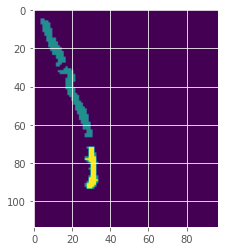

In [35]:
thumbnail = thumbnails_dict['07a7ef0ba3bb0d6564a73f4f3e1c2293']
# print(thumbnail[80])
plt.imshow(thumbnail)
indices = np.transpose(np.where(thumbnail>0.001))
# print(indices)
rand_index = random.randint(len(indices))
coord = indices[rand_index]
print(coord)

In [37]:
# Take only radboud slides
radboud = train.loc[train["data_provider"]=="radboud"]

# Take only wsi names
all_train_img_names = list(radboud.index)

# partition the data into training and validation splits using 85% of
# the data for training and the remaining 15% for validation
split_size = math.floor(VAL_SPLIT*len(all_train_img_names))
split = torch.utils.data.random_split(all_train_img_names,
									[split_size, len(all_train_img_names)-split_size], 
									generator=torch.Generator().manual_seed(42))

# unpack the data split
(train_img_names, val_img_names) = split
train_img_names = list(train_img_names)
val_img_names = list(val_img_names)
# print(train_img_names[:10])
# print(val_img_names[:10])

# create the train and validation datasets
trainDS = SegmentationDataset(wsi_names=train_img_names, mask_thumbnails=thumbnails_dict, pseudo_epoch_length=1024)
valDS = SegmentationDataset(wsi_names=val_img_names, mask_thumbnails=thumbnails_dict, pseudo_epoch_length=1024)
print(f"[INFO] found {len(trainDS)} samples in the training set...")
print(f"[INFO] found {len(valDS)} samples in the validation set...")

# create the training and validation data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=BATCH_SIZE, num_workers=4)
valLoader = DataLoader(valDS, shuffle=False,
	batch_size=BATCH_SIZE, num_workers=4)

Make Slide Dict: 100%|██████████| 774/774 [00:00<00:00, 1110.08it/s]


[INFO] found 1024 samples in the training set...
[INFO] found 1024 samples in the validation set...


In [ ]:
# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
#     in_channels=3, out_channels=1, init_features=32, pretrained=True)

In [38]:
# initialize our UNet model
unet = UNet().to(DEVICE)
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=INIT_LR)
# calculate steps per epoch for training and validation set
trainSteps = len(trainDS) // BATCH_SIZE
valSteps = len(valDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "val_loss": []}

In [39]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0

	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		# send the input to the device
		(x, y) = (x.to(DEVICE), y.to(DEVICE))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		y = y[:,:1]
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
    
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in valLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = unet(x)
			y = y[:,:1]
			totalValLoss += lossFunc(pred, y)

	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("Train loss: {:.6f}, Val loss: {:.4f}".format(
		avgTrainLoss, avgValLoss))

# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


 10%|█         | 1/10 [00:11<01:42, 11.38s/it]

[INFO] EPOCH: 1/10
Train loss: 0.355191, Val loss: 0.0073


 20%|██        | 2/10 [00:22<01:28, 11.04s/it]

[INFO] EPOCH: 2/10
Train loss: 0.019847, Val loss: 0.0095


 30%|███       | 3/10 [00:33<01:17, 11.02s/it]

[INFO] EPOCH: 3/10
Train loss: 0.002593, Val loss: 0.0017


 40%|████      | 4/10 [00:44<01:06, 11.02s/it]

[INFO] EPOCH: 4/10
Train loss: 0.001222, Val loss: 0.0014


 50%|█████     | 5/10 [00:55<00:54, 10.99s/it]

[INFO] EPOCH: 5/10
Train loss: 0.001120, Val loss: 0.0013


 60%|██████    | 6/10 [01:05<00:43, 10.94s/it]

[INFO] EPOCH: 6/10
Train loss: 0.001084, Val loss: 0.0012


 70%|███████   | 7/10 [01:16<00:32, 10.92s/it]

[INFO] EPOCH: 7/10
Train loss: 0.001069, Val loss: 0.0012


 80%|████████  | 8/10 [01:27<00:21, 10.88s/it]

[INFO] EPOCH: 8/10
Train loss: 0.001063, Val loss: 0.0012


 90%|█████████ | 9/10 [01:38<00:10, 10.87s/it]

[INFO] EPOCH: 9/10
Train loss: 0.001067, Val loss: 0.0012


100%|██████████| 10/10 [01:49<00:00, 10.93s/it]

[INFO] EPOCH: 10/10
Train loss: 0.001062, Val loss: 0.0012
[INFO] total time taken to train the model: 109.32s


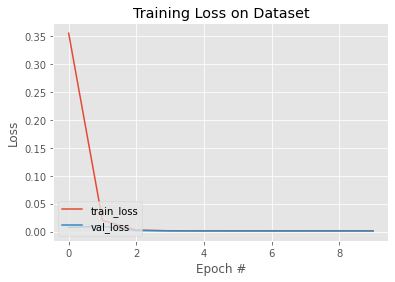

In [40]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
# serialize the model to disk
torch.save(unet, MODEL_PATH)

## Testing

In [ ]:
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

def make_predictions(model, imagePath):
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image.astype("float32") / 255.0
		# resize the image and make a copy of it for visualization
		image = cv2.resize(image, (128, 128))
		orig = image.copy()
		# find the filename and generate the path to ground truth
		# mask
		filename = imagePath.split(os.path.sep)[-1]
		groundTruthPath = os.path.join(config.MASK_DATASET_PATH,
			filename)
		# load the ground-truth segmentation mask in grayscale mode
		# and resize it
		gtMask = cv2.imread(groundTruthPath, 0)
		gtMask = cv2.resize(gtMask, (config.INPUT_IMAGE_HEIGHT,
			config.INPUT_IMAGE_HEIGHT))

In [ ]:
# Take only wsi names
test_img_names = list(test.index)

# create the test dataset
testDS = SegmentationDataset(wsi_names=test_img_names, mask_thumbnails=thumbnails_dict, pseudo_epoch_length=1024)
print(f"[INFO] found {len(testDS)} samples in the test set...")

# create the test data loader
testLoader = DataLoader(testDS, shuffle=True,
	batch_size=BATCH_SIZE, num_workers=4)